# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [59]:
USER_NAME = u"Павлов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = \frac{2w_i}{C}-\frac{1}{N} \frac{\sum_j log(\sigma(y^{(j)}g(x^{(j)})))}{\partial w_i} = \frac{2w_i}{C} - \frac{1}{N} \sum_j \frac{1}{\sigma(y^{(j)}g(x^{(j)}))} \frac{\sigma(y^{(j)}g(x^{(j)}))}{\partial w_i} = \frac{2w_i}{C} - \frac{1}{N} \sum_j \frac{1}{\sigma(y^{(j)}g(x^{(j)}))} \frac{e^{-y^{(j)}g(x^{(j)})}}{(1 + e^{-y^{(j)}g(x^{(j)})})^2}\frac{y^{(j)}g(x^{(j)})}{\partial w_i} = \frac{2w_i}{C} - \frac{1}{N} \sum_j \frac{1}{\sigma(y^{(j)}g(x^{(j)}))} \frac{e^{-y^{(j)}g(x^{(j)})}}{(1 + e^{-y^{(j)}g(x^{(j)})})^2}(y^{(j)}x^{(i)}) = \frac{2w_i}{C} - \frac{1}{N} \sum_j \frac{e^{-y^{(j)}g(x^{(j)})}}{(1 + e^{-y^{(j)}g(x^{(j)})})}(y^{(j)}x^{(i)})$$

## Имплементация (5 баллов)

In [300]:
from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    def sigma(self, z):
        return 1.0 / (1 + np.exp(-z))

    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.w = np.random.normal(0, 1, (X.shape[1]))
        self.w0 = np.random.normal(0, 1)
        self.errors_model = []
        self.max_y = y.max()
        self.min_y = y.min()
        y[self.max_y] = 1.
        y[self.min_y] = -1.
        N = X.shape[0]
        for epoch in range(self.max_epoch):
            inds = np.arange(N)
            np.random.shuffle(inds)
            for i in inds:
                g_x = ((X[i] * self.w).sum() + self.w0) * y[i]
                s = 2 * self.w / self.C - X[i] * (
                    (self.sigma2(g_x) / self.sigma(g_x)) * y[i]
                ) / N
                delta_w0 = -(self.sigma2(g_x) / self.sigma(g_x) * y[i]) / N
                self.w -= self.alpha * s / (epoch + 1)
                self.w0 -= self.alpha * delta_w0 / (epoch + 1)
            self.errors_model.append(
                1 / N * np.sum(
                    np.log(1 + np.exp(- y * np.sum(self.w * X, axis=1)))
                ) + 1 / self.C * np.sum(self.w ** 2)
            )
        return self

    def sigma2(self, z):
        return (np.exp(-z)) / ((1 + np.exp(-z)) ** 2)

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y = np.sign((X * self.w).sum(axis=1) + self.w0)
        max_ind = y == 1.
        min_ind = y != 1.
        y[max_ind] = self.max_y
        y[min_ind] = self.min_y
        return y

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        y = self._sigma((X * self.w).sum(axis=1) + self.w0)
        return np.array([[x, 1 - x] for x in y])


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

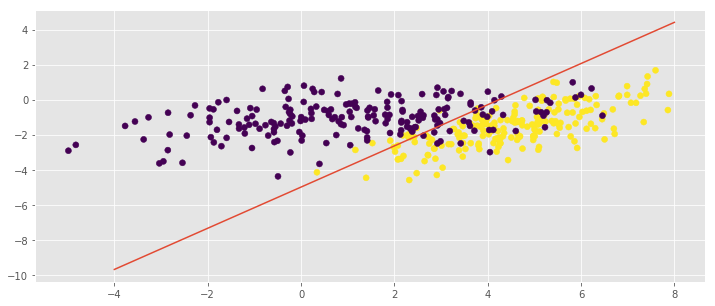

In [269]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)
X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
clf = MySGDClassifier(1000, 10, 1000)
clf.fit(X, y)
x_t = np.linspace(-4, 8)
y_t = (x_t * clf.w[0] + clf.w0) / (-clf.w[1])
plt.plot(x_t, y_t)
plt.scatter(X[:, 0], X[:, 1], c=y)


## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [222]:
from sklearn.datasets import make_classification

In [280]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

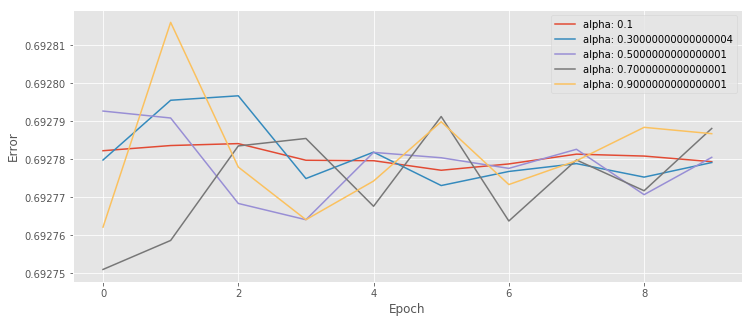

In [281]:
max_epoch = 10
for a in np.arange(0.1, 1.0, 0.2):
    clf = MySGDClassifier(alpha=a, max_epoch=max_epoch, C=100)
    clf.fit(X, y)
    plt.plot(
        np.arange(len(clf.errors_model)),
        clf.errors_model, label='alpha: {}'.format(a)
    )
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()


## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [291]:
plots = []
for c in np.logspace(3, -3, 10):
    clf = MySGDClassifier(alpha=0.1, max_epoch=10, C=c)
    clf.fit(X, y)
    plots.append(clf.w)

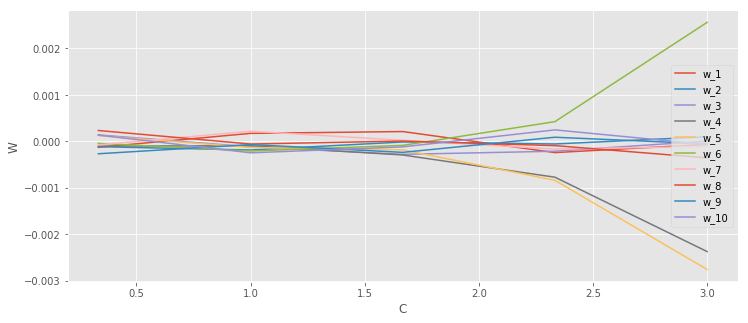

In [299]:
size = X.shape[1]
for i in range(size):
    plt.plot(np.linspace(3, -3, 10), [x[i] for x in plots])
plt.ylabel("W")
plt.xlabel("C")
plt.legend(["w_{}".format(i+1) for i in range(X.shape[1])])
plt.show()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [225]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [226]:
df_data.shape

(500000, 45)

In [227]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [228]:
df_data.shape

(500000, 44)

In [229]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [230]:
## Youd Code Here

len(np.unique(df_data['opponent_hero_card_id'])) 

9

In [231]:
len(np.unique(df_data['player_hero_card_id'])) 

9

In [232]:
df_data = pd.get_dummies(
    df_data, columns=['opponent_hero_card_id', 'player_hero_card_id']
)


In [233]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


In [234]:
df_data.shape

(500000, 60)

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [235]:
## Youd Code Here
#new_col = 

X = df_data[[col for col in df_data.columns if 'decision' not in col]]
y = df_data['decision']

In [236]:
X.shape

(500000, 59)

In [237]:
y.shape

(500000,)

In [238]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [239]:
model = Pipeline([('StandardScaler', StandardScaler()),
                  ('MySGDClassifier', MySGDClassifier(max_epoch=10, C=100, alpha=1.5))])
model.fit(X, y)

Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('MySGDClassifier', MySGDClassifier(C=100, alpha=1.5, max_epoch=10))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [240]:
## Youd Code Here
from sklearn.metrics import roc_auc_score


In [241]:
filepath = 'testData_tabular_chunk5.csv'
df_test_data = pd.read_csv(filepath, sep=',')
df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')

In [242]:
y_test = pd.read_table('deprecated_testLabels.txt', names=['decision'])

In [243]:
df_test_data.head().T

gamestate_id,1304374,4383331,3544947,4282915,4327924
decision,NaN,NaN,NaN,NaN,NaN
turn,5.0,9.0,16.0,3.0,5.0
opponent_armor,0.0,0.0,0.0,0.0,0.0
opponent_attack,0.0,3.0,0.0,0.0,0.0
opponent_hero_card_id,981.0,754.0,798.0,326.0,25.0
opponent_hp,23.0,16.0,16.0,30.0,30.0
opponent_special_skill_used,0.0,0.0,1.0,0.0,0.0
opponent_weapon_durability,0.0,1.0,0.0,0.0,0.0
opponent_crystals_all,4.0,8.0,10.0,2.0,4.0
opponent_crystals_current,0.0,3.0,2.0,2.0,1.0


In [244]:
df_test_data.shape

(500000, 44)

In [245]:
df_test_data.head()

,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
gamestate_id,,,,,,,,,,,,,,,,,,,,,
1304374,NaN,5,0,0,981,23,0,0,4,0,...,5,5,2,1,0,3,1,6,11,9
4383331,NaN,9,0,3,754,16,0,1,8,3,...,9,12,3,1,0,4,4,13,14,13
3544947,NaN,16,0,0,798,16,1,0,10,2,...,20,29,0,1,0,1,0,0,5,0
4282915,NaN,3,0,0,326,30,0,0,2,2,...,0,0,3,1,0,4,0,12,12,11
4327924,NaN,5,0,0,25,30,0,0,4,1,...,1,3,2,2,0,4,0,8,15,9


In [246]:
df_test_data.drop('decision', inplace=True, axis=1)

In [247]:
df_test_data.shape

(500000, 43)

In [248]:
df_test_data = pd.get_dummies(
    df_test_data, columns=['opponent_hero_card_id', 'player_hero_card_id']
)

In [249]:
df_test_data.shape

(500000, 59)

In [250]:
df_test_data.shape

(500000, 59)

In [251]:
y_test.shape

(1250000, 1)

In [252]:
y_test = y_test[:500000]

In [253]:
y_test.shape

(500000, 1)

In [254]:
y_pred = model.predict_proba(df_test_data)

In [255]:
print(roc_auc_score(y_test, y_pred[:, 0]))

0.7323485418614848
